In [ ]:
# Cell 1: Extract the Dataset

import os
import zipfile

ZIP_FILE_NAME = 'animal90.zip'
EXTRACTED_DIR = 'animal_90_dataset'

if os.path.exists(ZIP_FILE_NAME):
    if not os.path.exists(EXTRACTED_DIR):
        print(f"Found {ZIP_FILE_NAME}. Extracting...")
        with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
            zip_ref.extractall(EXTRACTED_DIR)
        print("Extraction complete.")
    else:
        print("Dataset already extracted.")
else:
    print(f"Error: {ZIP_FILE_NAME} not found. Please upload the file to your Colab session.")

Found animal90.zip. Extracting...
Extraction complete.


In [ ]:
# Cell 2: Set up Data Generators

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set image dimensions and batch size
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 32

# The base directory where your images are located after unzipping
base_dir = os.path.join('animal_90_dataset', 'animals', 'animals')

# Training generator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data for validation
)

# Validation generator (no augmentation, only rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print("\nData generators created successfully.")

Found 4319 images belonging to 90 classes.
Found 1079 images belonging to 90 classes.

Data generators created successfully.


In [ ]:
# Cell 3: Build the Model

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
)

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Add custom layers for our classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture built successfully.")
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model architecture built successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,660,058 (94.07 MB)

 Trainable params: 1,095,258 (4.18 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Cell 4: Train the Model

print("\nStarting model training...")
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

print("\nModel training complete.")


Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 104s 666ms/step - accuracy: 0.2983 - loss: 3.3036 - val_accuracy: 0.7878 - val_loss: 0.7551
Epoch 2/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 76s 560ms/step - accuracy: 0.7024 - loss: 1.1112 - val_accuracy: 0.8304 - val_loss: 0.6175
Epoch 3/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 77s 569ms/step - accuracy: 0.7733 - loss: 0.8279 - val_accuracy: 0.8526 - val_loss: 0.5451
Epoch 4/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 596ms/step - accuracy: 0.8118 - loss: 0.6470 - val_accuracy: 0.8239 - val_loss: 0.5718
Epoch 5/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 76s 562ms/step - accuracy: 0.8370 - loss: 0.5463 - val_accuracy: 0.8462 - val_loss: 0.5610
Epoch 6/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 76s 567ms/step - accuracy: 0.8329 - loss: 0.5454 - val_accuracy: 0.8517 - val_loss: 0.5188
Epoch 7/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 80s 594ms/step - accuracy: 0.8526 - loss: 0.4689 - val_accuracy: 0.8582 - val_loss: 0.5132
Epoch 8/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 75s 553ms/step - accuracy: 0.8598 - loss: 

In [ ]:
# Cell 5: Evaluate the Model

print("\nEvaluating the final model performance...")
loss, accuracy = model.evaluate(validation_generator)
print(f"\nFinal Validation Accuracy: {accuracy:.4f}")


Evaluating the final model performance...
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.8734 - loss: 0.4890

Final Validation Accuracy: 0.8656


In [ ]:
# Save the trained model
model_filename = "animal_classifier_model.h5"
model.save(model_filename)
print(f"Model saved as {model_filename}")

# --- Optional: Code to load the model later ---
# If you ever need to load the model in a new session, you can use this code:
# from tensorflow.keras.models import load_model
# loaded_model = load_model(model_filename)
# print("Model loaded successfully!")

Model saved as animal_classifier_model.h5


Model loaded successfully!
Loaded 90 class names.

Uploading an image to test...


Saving deer.webp to deer.webp
Uploaded file: deer.webp
Preprocessed image shape: (1, 224, 224, 3)

Making a prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Prediction Complete!
Predicted Class: deer
Confidence: 0.58


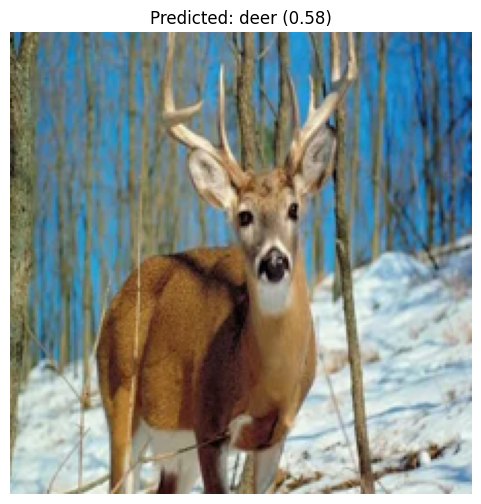

In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# --- Step 1: Load the saved model ---
model_filename = "animal_classifier_model.h5"
try:
    model = tf.keras.models.load_model(model_filename)
    print("Model loaded successfully!")
except OSError as e:
    print(f"Error: Could not find the model file '{model_filename}'.")
    print("Please make sure you have run the 'save model' cell and that the file is in your session.")
    # Exit if the model file is not found
    exit()

# --- Step 2: Get the class names ---
# The model outputs a class index, so we need the names to interpret it
# We'll regenerate the list of class names from the extracted dataset directory
base_dir = os.path.join('animal_90_dataset', 'animals', 'animals')
class_names = sorted(os.listdir(base_dir))
print(f"Loaded {len(class_names)} class names.")


# --- Step 3: Upload a new image ---
print("\nUploading an image to test...")
uploaded = files.upload()

# Get the name of the uploaded file
uploaded_filename = next(iter(uploaded))
print(f"Uploaded file: {uploaded_filename}")


# --- Step 4: Preprocess the uploaded image ---
try:
    # Open the image using PIL
    image = Image.open(uploaded_filename)

    # Resize the image to match the model's input size
    image = image.resize((224, 224))

    # Convert the image to a NumPy array
    img_array = np.array(image)

    # Normalize the pixel values to the range [0, 1]
    img_array = img_array / 255.0

    # Add a batch dimension (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Check the shape of the preprocessed image
    print(f"Preprocessed image shape: {img_array.shape}")

except Exception as e:
    print(f"Error processing the uploaded image: {e}")
    exit()


# --- Step 5: Make a prediction ---
print("\nMaking a prediction...")
predictions = model.predict(img_array)

# The prediction is an array of probabilities. Find the highest one.
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]
confidence_score = predictions[0][predicted_class_index]

# --- Step 6: Display the result ---
print(f"\nPrediction Complete!")
print(f"Predicted Class: {predicted_class_name}")
print(f"Confidence: {confidence_score:.2f}")

# Display the uploaded image with the prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {predicted_class_name} ({confidence_score:.2f})")
plt.axis('off')
plt.show()


Uploading an image to test...


Saving lion.webp to lion.webp
Uploaded file: lion.webp
Preprocessed image shape: (1, 224, 224, 3)

Making a prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Prediction Complete!
Predicted Class: lion
Confidence: 1.00


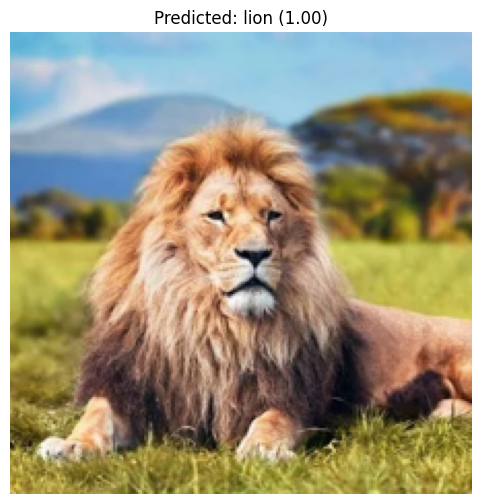

In [ ]:
# --- Step 3: Upload a new image ---
print("\nUploading an image to test...")
uploaded = files.upload()

# Get the name of the uploaded file
uploaded_filename = next(iter(uploaded))
print(f"Uploaded file: {uploaded_filename}")


# --- Step 4: Preprocess the uploaded image ---
try:
    # Open the image using PIL
    image = Image.open(uploaded_filename)

    # Resize the image to match the model's input size
    image = image.resize((224, 224))

    # Convert the image to a NumPy array
    img_array = np.array(image)

    # Normalize the pixel values to the range [0, 1]
    img_array = img_array / 255.0

    # Add a batch dimension (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Check the shape of the preprocessed image
    print(f"Preprocessed image shape: {img_array.shape}")

except Exception as e:
    print(f"Error processing the uploaded image: {e}")
    exit()


# --- Step 5: Make a prediction ---
print("\nMaking a prediction...")
predictions = model.predict(img_array)

# The prediction is an array of probabilities. Find the highest one.
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]
confidence_score = predictions[0][predicted_class_index]

# --- Step 6: Display the result ---
print(f"\nPrediction Complete!")
print(f"Predicted Class: {predicted_class_name}")
print(f"Confidence: {confidence_score:.2f}")

# Display the uploaded image with the prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {predicted_class_name} ({confidence_score:.2f})")
plt.axis('off')
plt.show()

In [ ]:
# Code to list the class names

import os

# Define the path to the main directory containing the class folders
base_dir = os.path.join('animal_90_dataset', 'animals', 'animals')

# Check if the directory exists before trying to list its contents
if os.path.exists(base_dir):
    # os.listdir() returns a list of all entries (files and directories)
    # in the specified path. Since our classes are directories, this works.
    class_names = sorted(os.listdir(base_dir))

    # Print the class names
    print(f"Found {len(class_names)} classes:")
    for name in class_names:
        print(f"- {name}")
else:
    print(f"Error: The directory '{base_dir}' does not exist.")
    print("Please make sure you have extracted the dataset correctly.")

Found 90 classes:
- antelope
- badger
- bat
- bear
- bee
- beetle
- bison
- boar
- butterfly
- cat
- caterpillar
- chimpanzee
- cockroach
- cow
- coyote
- crab
- crow
- deer
- dog
- dolphin
- donkey
- dragonfly
- duck
- eagle
- elephant
- flamingo
- fly
- fox
- goat
- goldfish
- goose
- gorilla
- grasshopper
- hamster
- hare
- hedgehog
- hippopotamus
- hornbill
- horse
- hummingbird
- hyena
- jellyfish
- kangaroo
- koala
- ladybugs
- leopard
- lion
- lizard
- lobster
- mosquito
- moth
- mouse
- octopus
- okapi
- orangutan
- otter
- owl
- ox
- oyster
- panda
- parrot
- pelecaniformes
- penguin
- pig
- pigeon
- porcupine
- possum
- raccoon
- rat
- reindeer
- rhinoceros
- sandpiper
- seahorse
- seal
- shark
- sheep
- snake
- sparrow
- squid
- squirrel
- starfish
- swan
- tiger
- turkey
- turtle
- whale
- wolf
- wombat
- woodpecker
- zebra



Uploading an image to test...


Saving ele.webp to ele.webp
Uploaded file: ele.webp
Preprocessed image shape: (1, 224, 224, 3)

Making a prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step

Prediction Complete!
Predicted Class: elephant
Confidence: 1.00


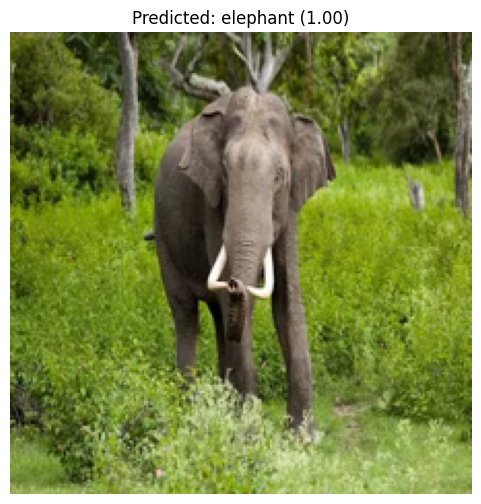

In [ ]:
# --- Step 3: Upload a new image ---
print("\nUploading an image to test...")
uploaded = files.upload()

# Get the name of the uploaded file
uploaded_filename = next(iter(uploaded))
print(f"Uploaded file: {uploaded_filename}")


# --- Step 4: Preprocess the uploaded image ---
try:
    # Open the image using PIL
    image = Image.open(uploaded_filename)

    # Resize the image to match the model's input size
    image = image.resize((224, 224))

    # Convert the image to a NumPy array
    img_array = np.array(image)

    # Normalize the pixel values to the range [0, 1]
    img_array = img_array / 255.0

    # Add a batch dimension (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Check the shape of the preprocessed image
    print(f"Preprocessed image shape: {img_array.shape}")

except Exception as e:
    print(f"Error processing the uploaded image: {e}")
    exit()


# --- Step 5: Make a prediction ---
print("\nMaking a prediction...")
predictions = model.predict(img_array)

# The prediction is an array of probabilities. Find the highest one.
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]
confidence_score = predictions[0][predicted_class_index]

# --- Step 6: Display the result ---
print(f"\nPrediction Complete!")
print(f"Predicted Class: {predicted_class_name}")
print(f"Confidence: {confidence_score:.2f}")

# Display the uploaded image with the prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {predicted_class_name} ({confidence_score:.2f})")
plt.axis('off')
plt.show()

In [ ]:
# Save the trained model
model_filename = "animal_classifier_model.h5"
model.save(model_filename)
print(f"Model saved as {model_filename}")

# --- Optional: Code to load the model later ---
# If you ever need to load the model in a new session, you can use this code:
# from tensorflow.keras.models import load_model
# loaded_model = load_model(model_filename)
# print("Model loaded successfully!")

Model saved as animal_classifier_model.h5
